### 1. Library 불러오기, SEED 설정, CUDA 사용

In [5]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 맥북 용
# GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")
device = torch.device("mps")

# 윈도우 용(Colab)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')


mps 사용 가능 여부: True
mps 지원 환경 여부: True
mps is available


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [6]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:1000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (60% / 20% / 20%)
train_split = int((X.size(0)) * 0.6)
valid_split = int((X.size(0)) * 0.8)

X_train_seq = X[:train_split]
X_val_seq = X[train_split:valid_split]
X_test_seq = X[valid_split:]
y_train_seq = y[:train_split]
y_val_seq = y[train_split:valid_split]
y_test_seq = y[valid_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([707, 20, 77]) torch.Size([707, 1])
Train Size: torch.Size([424, 20, 77]) torch.Size([424, 1])
Valid Size: torch.Size([141, 20, 77]) torch.Size([141, 1])
Test Size: torch.Size([142, 20, 77]) torch.Size([142, 1])


In [7]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 32 # 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [8]:
# # 주식 시계열 데이터의 형태: [배치 크기, 시퀀스 길이, 특성 수]
# # 여기서 특성 수는 주가, 거래량, 기술적 지표 등 다양한 특성을 포함합니다.

# class CNNLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(CNNLSTMModel, self).__init__()
        
#         # CNN 레이어
#         self.cnn = nn.Conv1d(in_channels=input_size[-1], out_channels=64, kernel_size=3)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(kernel_size=2)
        
#         # LSTM 레이어
#         self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
#         # Fully Connected 레이어
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         # CNN 레이어 적용
#         x = self.cnn(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
        
#         # LSTM 레이어 적용
#         lstm_out, _ = self.lstm(x)
        
#         # Fully Connected 레이어에 입력
#         out = self.fc(lstm_out[:, -1, :])
        
#         return out

# num_features = X.size(2)

# # 모델 인스턴스화
# input_size = [batch_size, seq_len, num_features]  # 예: [32, 20, 5]
# hidden_size = 64
# num_layers = 2

# model = CNNLSTMModel(input_size, hidden_size, num_layers).to(device)

# print(model)


In [9]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CNNLSTMModel, self).__init__()
        
        # CNN 레이어
        # in_channels=input_size[-1]이면 안됨. 즉 feature_dims면 안되고 sequence_length(=20, 40, 80...) 여야 함.
        '''
        in_channels = 일반적인 이미지와 같은 2D 데이터를 다룰 때는 특성 맵(channel)을 채널로 인식함.
        그러나 주식 시계열 데이터와 같은 1D 데이터의 경우 시퀀스 길이에 해당하는 차원이 채널로 간주됨.
        이에 따라 'in_channels'에는 시퀀스 길이를 입력해야 함.
        즉, 주식 시게열 데이터에서는 'in_channels'에는 시퀀스의 길이가 들어가야 올바르게 수행됨.
        '''
        self.cnn = nn.Conv1d(in_channels=input_size[1], out_channels=64, kernel_size=3) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully Connected 레이어
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # CNN 레이어 적용
        x = self.cnn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # LSTM 레이어 적용
        '''
        LSTM 레이어에 입력을 전달하고, LSTM의 출력과 은닉 상태를 받는 부분
        x.permute(0, 2, 1): 입력텐서 x의 차원을 변경. 일반적으로 LSTM 레이어는 시간 단계(seq_len)를 두 번쨰 차원으로 받지만,
        Conv1d 레이어의 출력은 시간 단계가 세번째 차원에 위치함. 따라서 permute를 통해 차원을 변경하여 LSTM 레이어에 올바른 형태의 입력을 제공
        여기서 0번째 차원은 배치 크기(batch_size)를 나타내며, 1번째 차원은 특성 수(num_features)를 나타냄. 마지막(2번째) 차원은 시간 단계(seq_len)를 나타냄
        self.lstm(x.permute(0, 2, 1)): 변경된 입력을 LSTM 레이어에 전달함. LSTM 입력으로 3D 텐서를 받으며,
        이 텐서는 배치 크기(batch_size), 시간 단계(seq_len),. 특성 수(num_features)의 형태를 가짐
        lstm_out, _: LSTM 레이어의 출력과 은닉 상태를 받음. 여기서 은닉 상태는 사용하지 않기 때문에 '_'로 무시. lstm_out은 LSTM 레이어의 출력으로, 각 시간 단계에
        해당하는 출력을 포함하는 3D 텐서임.
        '''
        lstm_out, _ = self.lstm(x.permute(0, 2, 1))
        
        # Fully Connected 레이어에 입력
        '''
        lstm_out[:, -1, :]: LSTM 레이어의 출력에서 마지막 시간 단계의 출력만 선택. 이는 시퀀스 예측을 위해 마지막 시간 단계의 정보만을 사용하고자 하는 것
        따라서 [:, -1, :]는 모든 배치와 모든 특성을 유지하면서 마지막 시간 단계의 출력을 선택함
        self.fc(lstm_out[:, -1, :]): 선택된 마지막 시간 단계의 출력을 Fully Connected(FC) 레이어에 입력함. FC 레이어는 입력된 LSTM 출력을 받아서 최종
        예측을 수행하는 역할을 함. 출력 크기는 1이며, 이는 주어진 입력에 대한 예측된 결과를 나타냄.
        '''
        out = self.fc(lstm_out[:, -1, :])
        
        return out

model = CNNLSTMModel(input_size=X.size(), hidden_size=32, num_layers=2).to(device)

### 4. 모델학습1: train 데이터만 가지고 학습

In [10]:
# # 학습1: train data만 가지고 학습 -> 과적합 이빠이~

# # 손실 함수와 옵티마이저 정의
# criterion = nn.BCEWithLogitsLoss()
# #criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # GPU 사용 가능 여부 확인
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_epochs = 100

# # 학습 루프
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
    
#     for batch_features, batch_targets in train_loader:
#         # 배치를 GPU로 전송
#         batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
#         # 모델에 대한 순전파 및 손실 계산
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_targets)
        
#         # 역전파 및 최적화
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     # 에폭마다 손실 출력
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


### 5. 모델학습2: train, valid를 이용한 과적합 방지되는 epoch 찾기

Epoch 1/100, Train Loss: 0.02293544923359493, Valid Loss: 0.024438940041454124
Epoch 2/100, Train Loss: 0.021384847332846443, Valid Loss: 0.02451746345411801
Epoch 3/100, Train Loss: 0.02132009616437948, Valid Loss: 0.02451127048925305
Epoch 4/100, Train Loss: 0.021304904571119346, Valid Loss: 0.024495448626525012
Epoch 5/100, Train Loss: 0.021297076963028818, Valid Loss: 0.024483293083542627
Epoch 6/100, Train Loss: 0.02129076561837826, Valid Loss: 0.024476811818197265
Epoch 7/100, Train Loss: 0.02128815524420648, Valid Loss: 0.024469592047075852
Epoch 8/100, Train Loss: 0.021283795108210365, Valid Loss: 0.02446920356006487
Epoch 9/100, Train Loss: 0.02128088980350854, Valid Loss: 0.024468173371984602
Epoch 10/100, Train Loss: 0.021278363634955208, Valid Loss: 0.024467038770093985
Epoch 11/100, Train Loss: 0.0212761049844184, Valid Loss: 0.024466010695653604
Epoch 12/100, Train Loss: 0.02127408545534566, Valid Loss: 0.024465118739621858
Epoch 13/100, Train Loss: 0.021272258095021517, 

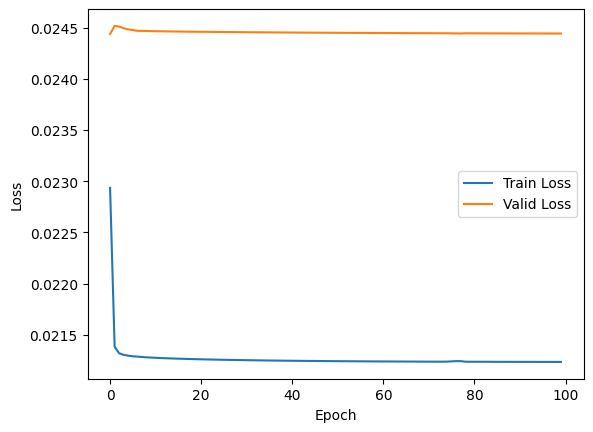

In [11]:
# # 학습2: valid를 이용한 과적합 방지 epoch 찾기

# # 학습과 검증 손실을 저장할 리스트 초기화
# train_losses = []
# valid_losses = []

# # # 손실 함수와 옵티마이저 정의
# criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
# #criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# num_epochs = 100

# # 검증 데이터에 대한 모델 성능 평가 함수 정의
# def evaluate(model, criterion, dataloader):
#     model.eval()  # 모델을 평가 모드로 설정
#     total_loss = 0.0
    
#     with torch.no_grad():
#         for batch_features, batch_targets in dataloader:
#             # 배치를 GPU로 전송
#             batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
#             # 모델에 대한 순전파 및 손실 계산
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_targets)
            
#             total_loss += loss.item()
    
#     return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# # 학습 루프
# for epoch in range(num_epochs):
#     model.train()  # 모델을 학습 모드로 설정
#     total_loss = 0.0
    
#     for batch_features, batch_targets in train_loader:
#         # 배치를 GPU로 전송
#         batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
#         # 모델에 대한 순전파 및 손실 계산
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_targets)
        
#         # 역전파 및 최적화
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     # 에폭마다 학습 손실 기록
#     train_loss = total_loss / len(train_loader.dataset)
#     train_losses.append(train_loss)
    
#     # 검증 데이터에 대한 손실 계산 및 기록
#     valid_loss = evaluate(model, criterion, valid_loader)
#     valid_losses.append(valid_loss)
    
#     # 에폭마다 손실 출력
#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

# # 손실 함수 시각화
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### 6. 모델학습3: Optuna + CV 추가

In [15]:
# 데이터 불러오기 / Optuna 용 -> valid 제거
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:1000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (70% / 30%)
split = int((X.size(0)) * 0.7)

X_train_seq = X[:split]
X_test_seq = X[split:]
y_train_seq = y[:split]
y_test_seq = y[split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([707, 20, 77]) torch.Size([707, 1])
Train Size: torch.Size([494, 20, 77]) torch.Size([494, 1])
Test Size: torch.Size([213, 20, 77]) torch.Size([213, 1])


In [17]:
# 학습 3: Optuna + CV 추가
import optuna
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
    # K-Fold 교차 검증 설정
    # k = 5  # 분할 수
    # kf = KFold(n_splits=k, shuffle=True, random_state=42)
    # TimeSeriesSplit 설정
    tscv = TimeSeriesSplit(n_splits=5, gap=0) # gap: valid 전 train 데이터의 마지막 몇개 데이터 포인트를 제거하느냐

    # 하이퍼파라미터 탐색 공간 정의
    input_size = X.size() # LSTM: X.shape[2](n_features), CNN-LSTM: X.size() -> CNN내에서 X.size(1)(seq_len)으로 input 실행
    hidden_size = trial.suggest_int('hidden_size', 5, 100, step=5)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    lr = trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001])
    num_epochs = 100  # 에폭 수는 고정값으로 설정

    # 교차 검증을 위한 전체 손실 초기화
    total_loss = 0.0

    for train_idx, val_idx in tscv.split(X):
        # 훈련 데이터와 검증 데이터로 분할
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # DataLoader 설정
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        # 모델, 손실 함수, 옵티마이저 정의
        model = CNNLSTMModel(input_size, hidden_size, num_layers).to(device)
        criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 모델 훈련
        model.train()
        for epoch in range(num_epochs):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # 검증 손실 계산
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)

        total_loss += val_loss

    # 평균 검증 손실을 반환
    avg_loss = total_loss / 5
    return avg_loss

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # 시도 횟수는 10으로 설정

print('Best trial:', study.best_trial.params)
print("Best trial's value:", study.best_trial.value)


[I 2024-02-28 13:52:28,422] A new study created in memory with name: no-name-23273313-f894-451b-a8a8-9980a358554c
[W 2024-02-28 13:52:59,387] Trial 0 failed with parameters: {'hidden_size': 100, 'num_layers': 2, 'lr': 0.01} because of the following error: RuntimeError('MPS backend out of memory (MPS allocated: 46.69 MB, other allocations: 9.02 GB, max allowed: 9.07 GB). Tried to allocate 156.25 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).').
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_4747/3352314322.py", line 46, in objective
    loss.backward()
  File "/opt/homebrew/lib/python3.8/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/opt/homebrew/lib/python3.8/site-pa

RuntimeError: MPS backend out of memory (MPS allocated: 46.69 MB, other allocations: 9.02 GB, max allowed: 9.07 GB). Tried to allocate 156.25 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

Accuracy: 0.6408
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/homebrew/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


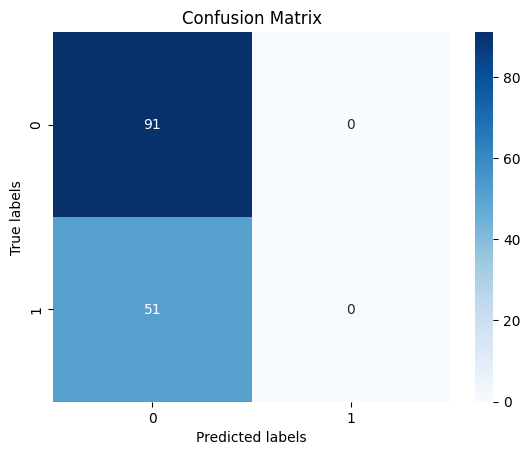

In [12]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.round(outputs).cpu().numpy()  # 이진 분류를 가정
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()